## Описание задачи

Датасет содержит сведения о 40 000 ресторанах Европы. Необходимо построить модель, которая должна быть способной предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

## Импортируем библиотеки и прочитаем файл:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns 
import re
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn.metrics import mean_absolute_error # инструменты для оценки точности модели
from sklearn.preprocessing import OrdinalEncoder # OrdinalEncoder для присвоения порядковых номеров множеству данных
from sklearn import metrics


In [2]:
# # Importing datasets.
# df_train = pd.read_csv(r'C:\Users\User\Desktop\Skillshare\Проект 3\main_task.csv')
# df_test = pd.read_csv(r'C:\Users\User\Desktop\Skillshare\Проект 3\kaggle_task.csv')
# sample_submission = pd.read_csv(r'C:\Users\User\Desktop\Skillshare\Проект 3\sample_submission.csv')

In [3]:
# # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
# df_train['Sample'] = 1 # помечаем где у нас трейн
# df_test['Sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
df = pd.read_csv(r'C:\Users\User\Desktop\Skillshare\Проект 3\main_task.csv')
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
20515,id_2469,Barcelona,"['Mediterranean', 'Spanish', 'Cafe']",2470.0,5.0,$,30.0,"[['Super good clean food', 'Very good value'],...",/Restaurant_Review-g187497-d2186678-Reviews-DA...,d2186678
27488,id_1420,Prague,"['Czech', 'Central European', 'International',...",1422.0,3.5,$,76.0,[['Good inexpensive meal and brisk helpful se....,/Restaurant_Review-g274707-d3446795-Reviews-Re...,d3446795
2936,id_3329,Barcelona,NaN,3330.0,4.5,NaN,23.0,"[['Lovely place to be', 'Great little find'], ...",/Restaurant_Review-g187497-d6276909-Reviews-Al...,d6276909
3466,id_12604,Paris,NaN,12606.0,3.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d12731915-Reviews-S...,d12731915
4923,id_5218,Berlin,"['Asian', 'Central Asian']",5220.0,3.5,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187323-d11749377-Reviews-B...,d11749377


## Внесем базовые переменные

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# Постоянный сегодняшний день
date_today = pd.to_datetime('2020-09-18')

## Предобработка 

In [6]:
def chart(col):
    """Показывает график"""
    df[col].value_counts(ascending=True).plot(kind='barh')


def hist(name, bins):
    """Показывает гистограмму"""
    return name.hist(bins=bins)


def pie_chart(df):
    """Показывает график Pie chart"""
    global_number_rest = df.value_counts(dropna=False)
    total_rest = global_number_rest.sum()
    explode = [0.1 for i in global_number_rest]
    global_number_rest.plot(kind='pie', figsize=(25, 25), explode=explode, fontsize=20, autopct=lambda v: int(v*total_rest/100),
                            title=df.name)
    plt.show()


def get_boxplot(column):
    """Показывает boxplot"""
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def value_counts(name):
    """Показывает уникальные значения"""
    display(pd.DataFrame(name.value_counts(dropna=False)))


def MAE(df_temp):
    """Обучает модель и показывает процент ошибок (MAE)"""
    y = df_temp['Rating']
    df_temp.drop(['Rating'], axis=1, inplace=True)
    X = df_temp

    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 20% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создадим модель
    regr = RandomForestRegressor(
        n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)

    # Т. к. целевая переменная кратна 0.5, добавим здесь округление y_pred до 0.5
    y_pred = np.round(y_pred*2)/2

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    print()
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print()

    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')

### Описание данных
* Restaurant_id — идентификационный номер ресторана / сети ресторанов
* City — город, в котором находится ресторан
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города
* Rating — рейтинг ресторана по данным TripAdvisor(именно это значение должна будет предсказывать модель)
* Price Range — диапазон цен в ресторане
* Number of Reviews — количество отзывов о ресторане
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана
* URL_TA — URL страницы ресторана на TripAdvosor
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Пропуски

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


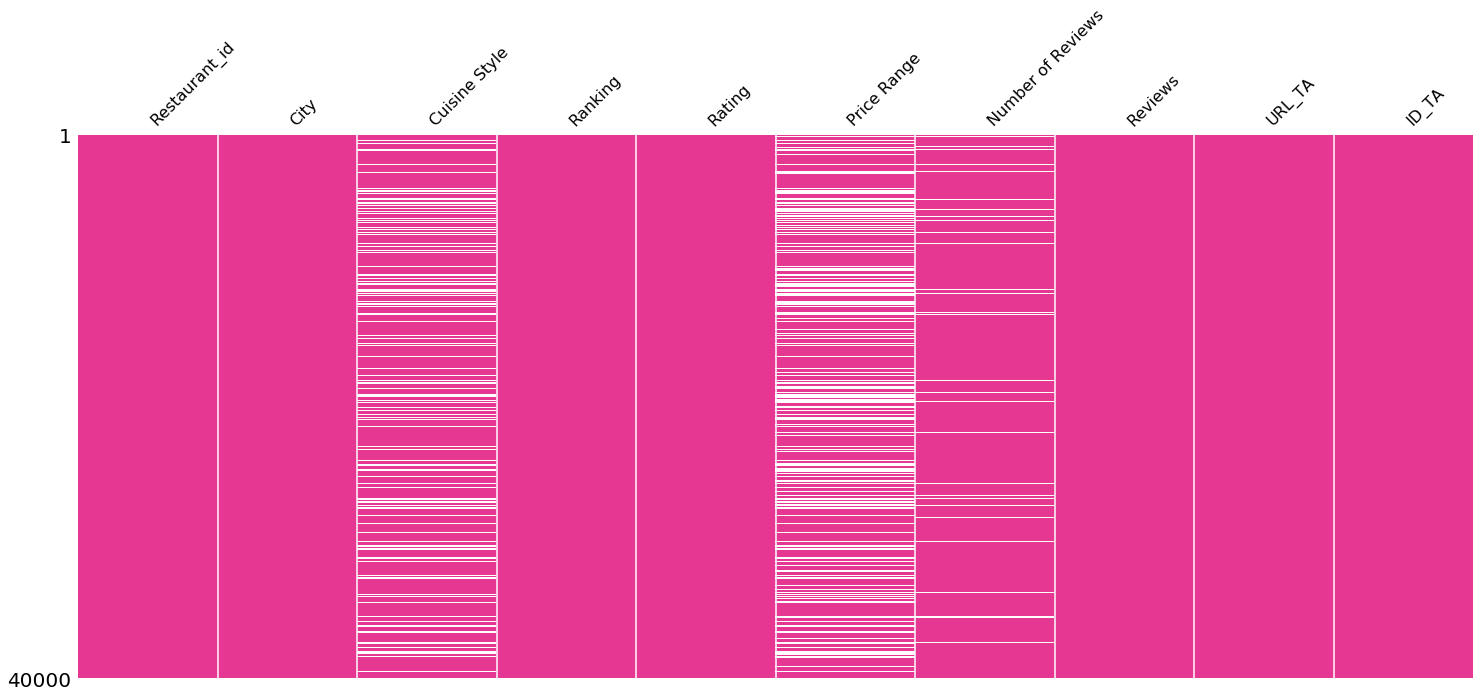

In [8]:
print(df.isna().sum(),msno.matrix(df, color=(0.905, 0.221, 0.578), sparkline=False))

### Обработка NAN

*Создадим новый признак  с информацией о том, где были пропуски и заполним пропуски нулями* 

In [9]:
df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Number_of_Reviews_isNAN'] = pd.isna(
    df['Number of Reviews']).astype('uint8')
df['Number of Reviews'].fillna(0, inplace=True)

#### Смотрим на дубликаты

In [10]:
df.duplicated().sum()

0

#### Смотрим на изночальную модель MAE

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished



MAE: 0.409



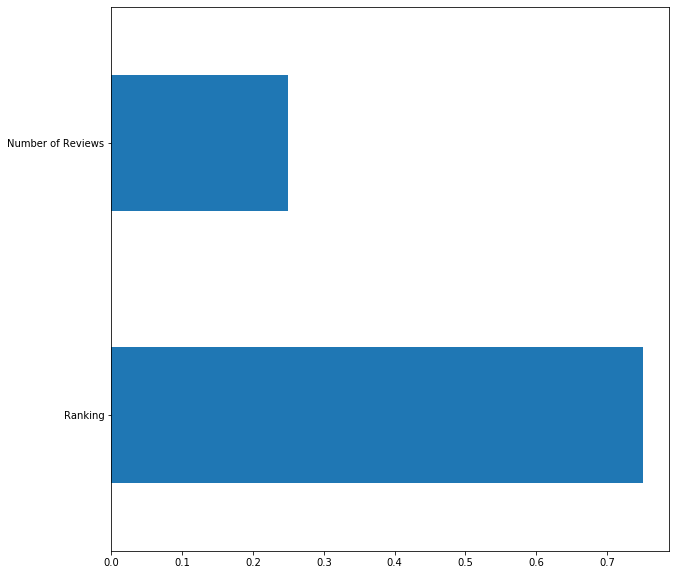

In [11]:
df_tmp = df[['Ranking', 'Number of Reviews', 'Rating']]
MAE(df_tmp)

## Обработка признаков
### Restaurant_id - идентификационный номер ресторана

*Удалим этот признак, для модели он не несет никакого смысла, а только создаст  шум*

In [12]:
df.drop(['Restaurant_id'], axis=1, inplace=True)

## Целевая переменная *Rating*
Рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказываться моделью)

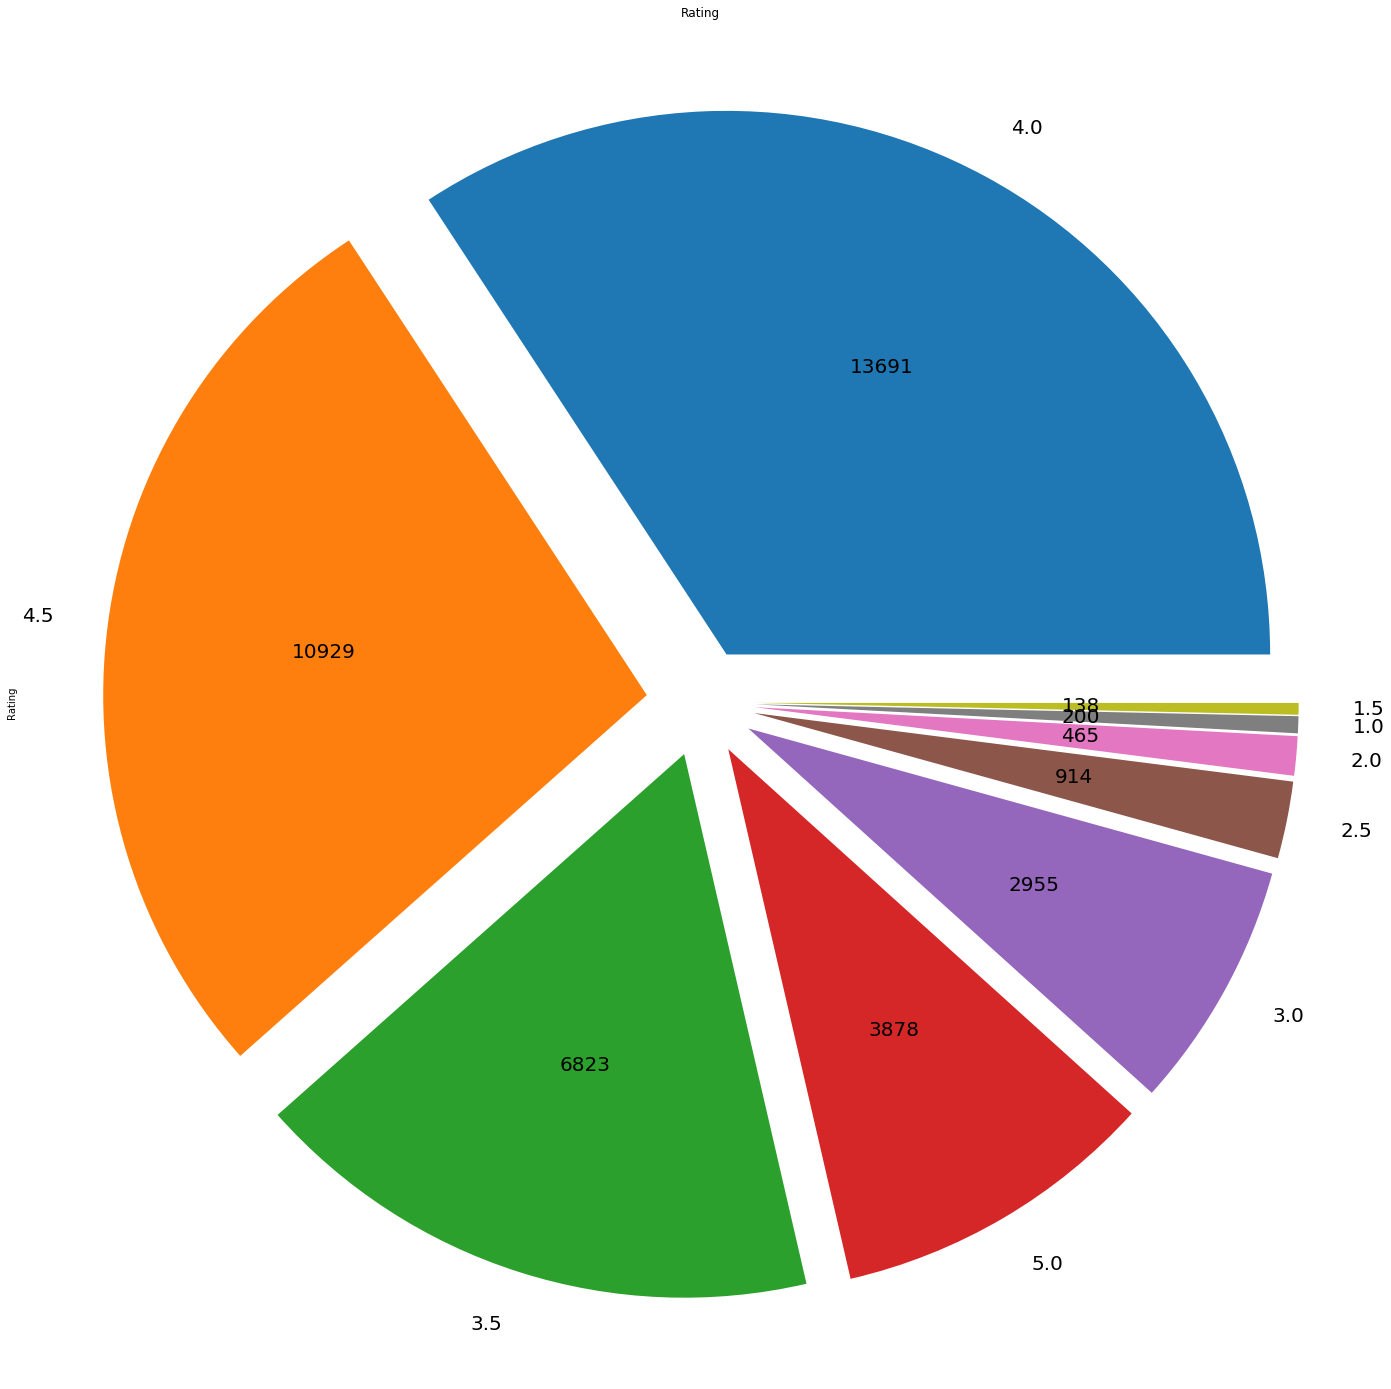

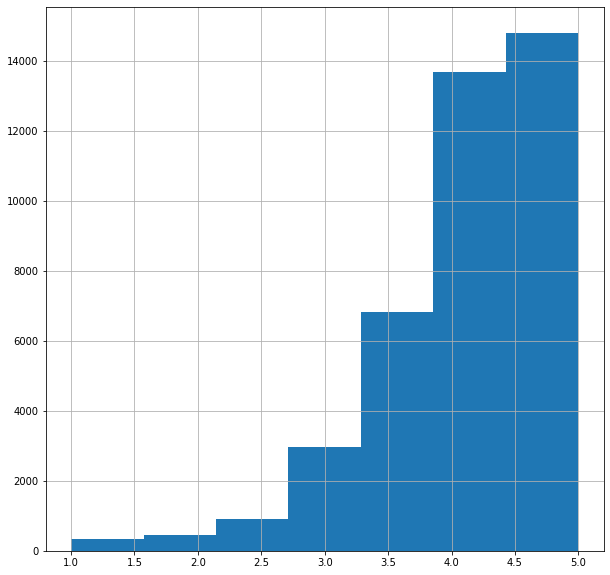

In [13]:
pie_chart(df['Rating'])
hist(df.Rating,7)

#### Посмотрим на выбросы 

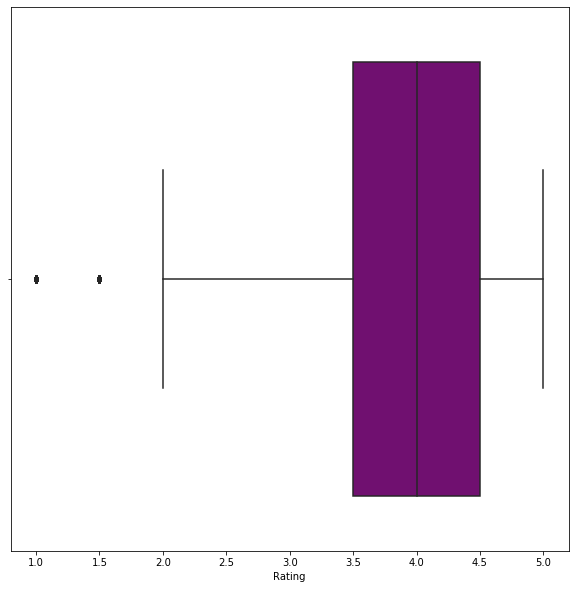

In [14]:
sns.boxplot(df.Rating, color='purple');

*Есть выбросы,но по моему мнению, такие оценки бывают. Трогать я их не буду*

### Работаем с городами

### City

,City
London,5757
Paris,4897
Madrid,3108
Barcelona,2734
Berlin,2155
Milan,2133
Rome,2078
Prague,1443
Lisbon,1300
Vienna,1166


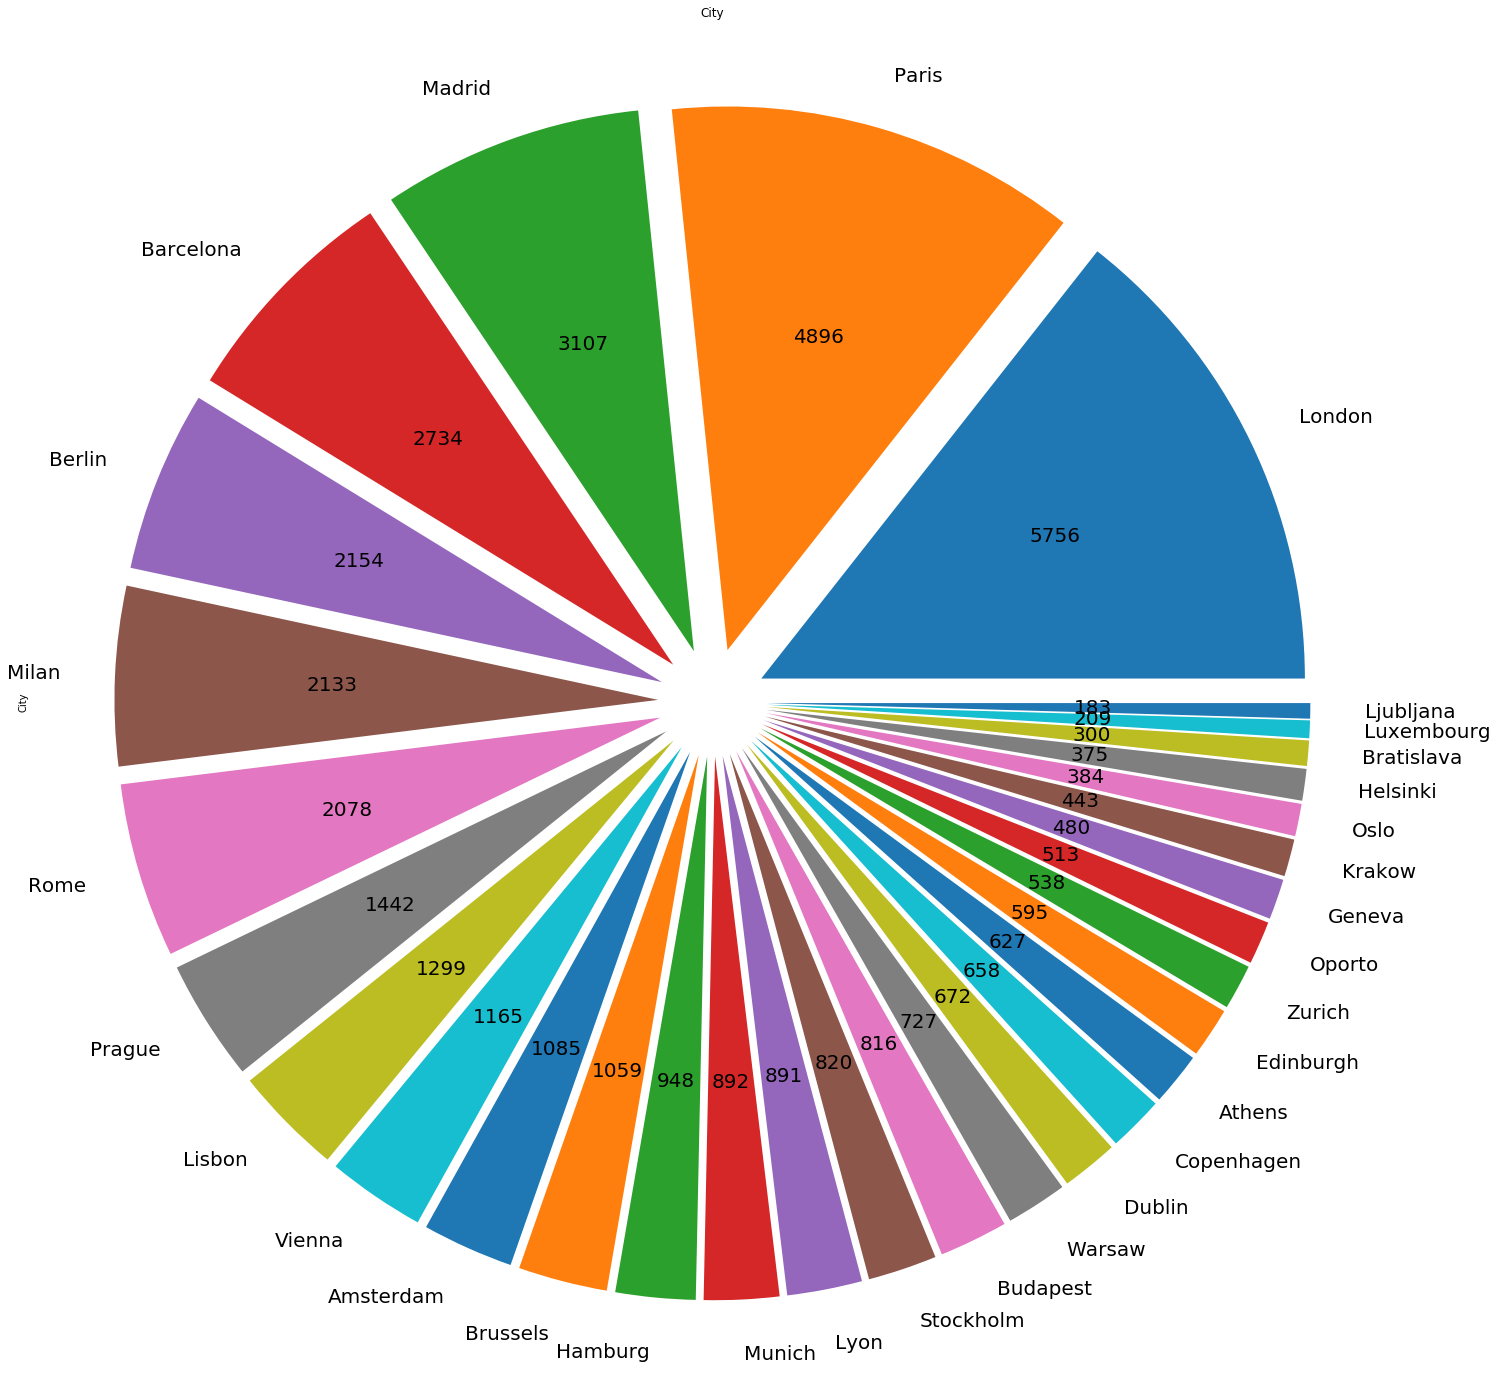

None None Кол-во городов:  31


In [15]:
print(value_counts(df['City']), pie_chart(df['City']),
      'Кол-во городов: ', df['City'].nunique())

**В интернете находим численность городов и добавим новый признак о количестве ресторанов в городе**

In [16]:
number_of_cities = {
    'London': 8787892,
    'Paris': 2140526,
    'Madrid': 3223334,
    'Barcelona': 1620343,
    'Berlin': 3601131,
    'Milan': 1366180,
    'Rome': 2872800,
    'Prague': 1280508,
    'Lisbon': 505526,
    'Vienna': 1840573,
    'Amsterdam': 859732,
    'Brussels': 144784,
    'Hamburg': 1830584,
    'Munich': 1456039,
    'Lyon': 515695,
    'Stockholm': 961609,
    'Budapest': 1749734,
    'Warsaw': 1758143,
    'Dublin': 553165,
    'Copenhagen': 615993,
    'Athens': 655780,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 766739,
    'Oslo': 673469,
    'Helsinki': 643272,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

df['Population'] = df['City'].apply(lambda x: number_of_cities[x])
df_tmp = df['City'].value_counts()
df['Number_of_restaurans'] = df['City'].apply(lambda x: df_tmp[x])

#### Создадим новый признак. Количество ресторанов на человека в городе

In [17]:
df['Density_restaurans'] = df['Number_of_restaurans'] / df['Population']

####  Создадим признак Capital - является ли город столицей.

In [18]:
capital_or_not = {
    'London': 1,
    'Paris': 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

df['Capital'] = df['City'].apply(lambda x: capital_or_not[x])

#### Создадим признак Country - название страны.

In [19]:
country_name = {
    'London': 'England',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Nederlands',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

df['Country'] = df['City'].apply(lambda x: country_name[x])

### Посмотрим на данные

,Country
Spain,5842
France,5789
England,5757
Italy,4211
Germany,3997
Portugal,1813
Czech,1443
Poland,1170
Austria,1166
Nederlands,1086


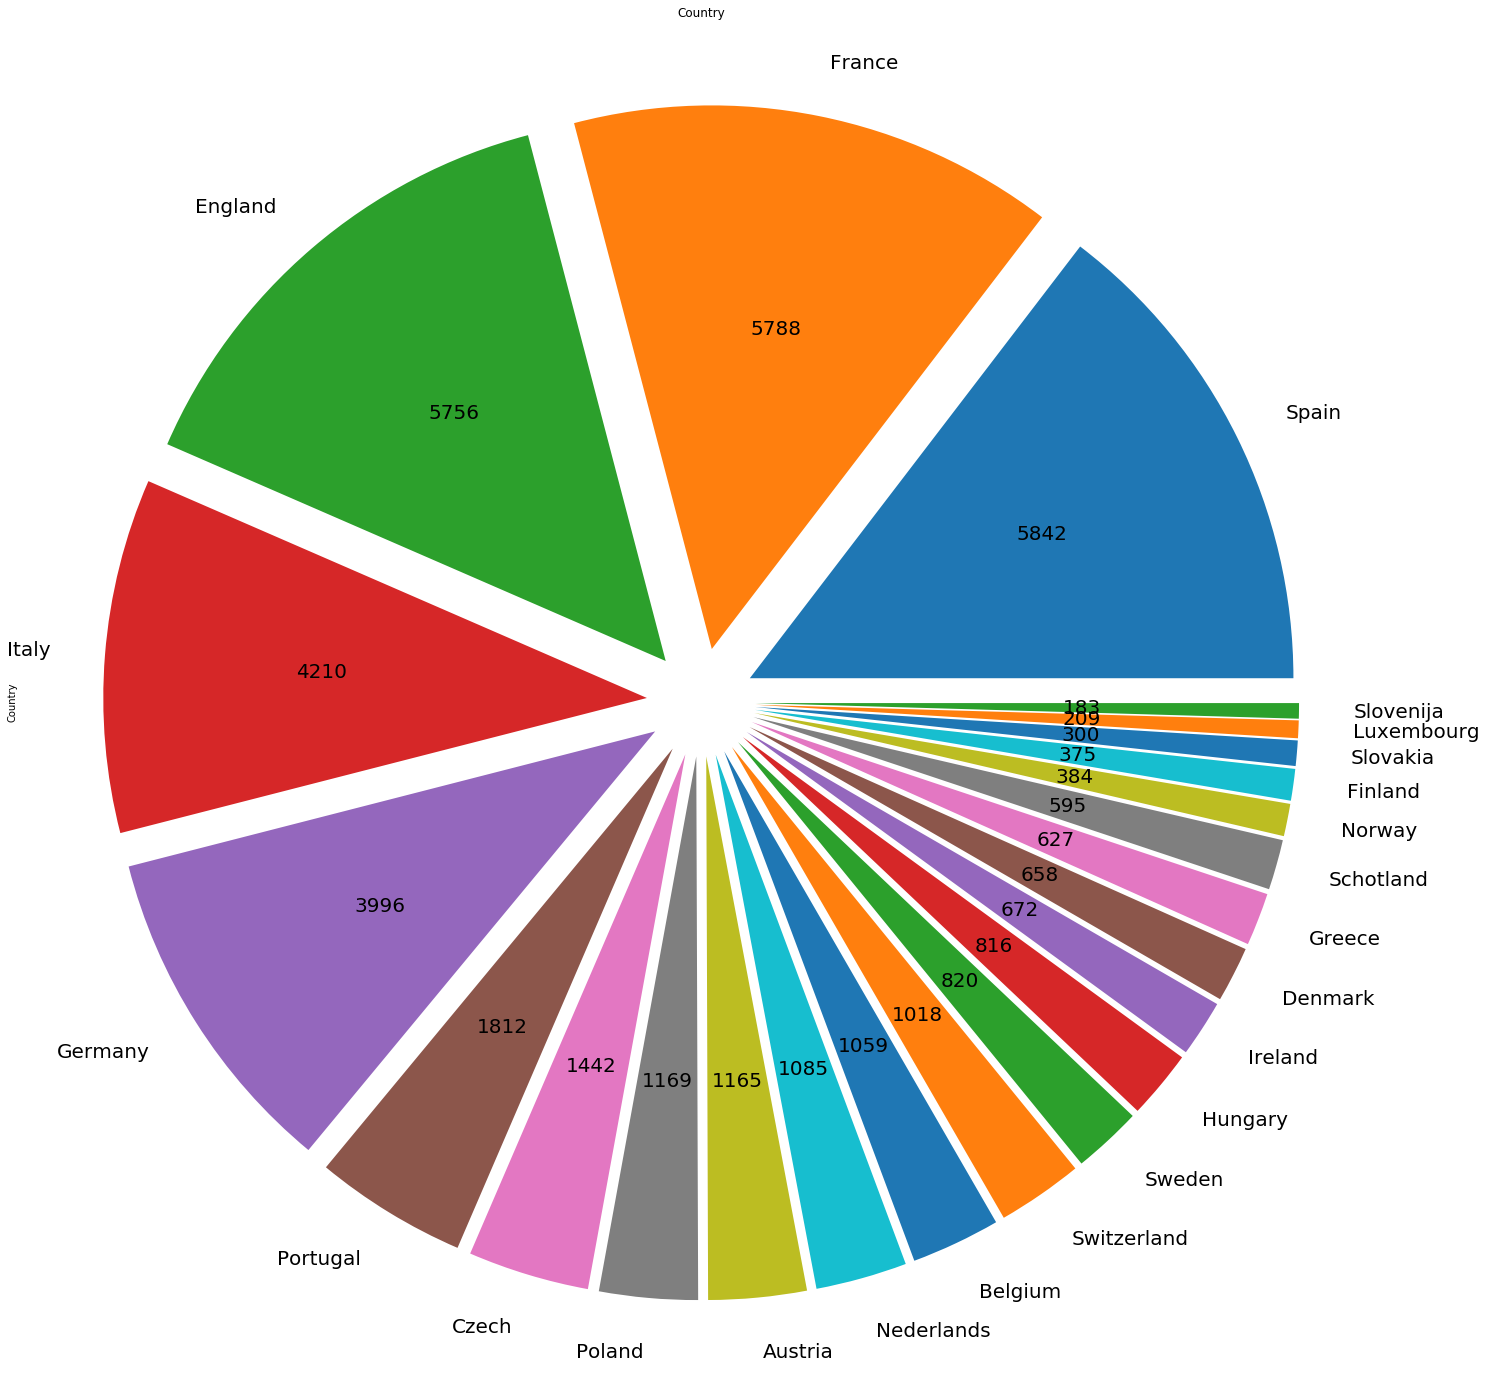

None None Кол-во стран:  23


In [20]:
print(value_counts(df['Country']), pie_chart(
    df['Country']), 'Кол-во стран: ', df['Country'].nunique())

#### Создадим признак о  количестве ресторанов в стране и коэффициент сосредоточенности ресторанов в городах страны.

In [21]:
df_tmp = df['Country'].value_counts()
df['Restaurants_in_Country'] = df['Country'].apply(lambda x: df_tmp[x])

In [22]:
df['Rest_City_concentration'] = df['Number_of_restaurans'] / df['Restaurants_in_Country']

In [23]:
df.dtypes

City                        object
Cuisine Style               object
Ranking                    float64
Rating                     float64
Price Range                 object
Number of Reviews          float64
Reviews                     object
URL_TA                      object
ID_TA                       object
Cuisine_Style_isNAN          uint8
Price_Range_isNAN            uint8
Number_of_Reviews_isNAN      uint8
Population                   int64
Number_of_restaurans         int64
Density_restaurans         float64
Capital                      int64
Country                     object
Restaurants_in_Country       int64
Rest_City_concentration    float64
dtype: object

*существует разная сосредоточенность ресторанов*


### Cоздадим признак ВВП  на душу населения
*Внешний источник: url*:https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D1%82%D1%80%D0%B0%D0%BD_%D0%BF%D0%BE_%D0%92%D0%92%D0%9F_(%D0%9F%D0%9F%D0%A1)_%D0%BD%D0%B0_%D0%B4%D1%83%D1%88%D1%83_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F

In [24]:
economies = {
    'England': 45741,
    'France': 45893,
    'Spain': 40172,
    'Germany': 52386, 
    'Italy': 39676, 
    'Czech': 37340,
    'Portugal': 32412,
    'Austria': 52172,
    'Nederlands': 56489,
    'Belgium': 48327,
    'Sweden': 53652, 
    'Hungary': 26448,
    'Poland': 32005,
    'Ireland': 79617, 
    'Denmark': 52279,
    'Greece': 29072,
    'Schotland': 45741, 
    'Switzerland': 65010,
    'Norway': 74357,
    'Finland': 46596, 
    'Slovakia': 35136,
    'Luxembourg': 106372,
    'Slovenija': 36741}
df['Country_economies'] = df['Country'].apply(lambda x: economies[x])

### Cоздадим признак cредний размер оплаты труда за 1 месяц в $

*Внешний источник: url*:https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D1%82%D1%80%D0%B0%D0%BD_%D0%BF%D0%BE_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B9_%D0%B7%D0%B0%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BD%D0%BE%D0%B9_%D0%BF%D0%BB%D0%B0%D1%82%D0%B5


In [25]:
salary = {
    'Spain': 2495,
    'France': 3417,
    'England': 3413,
    'Italy': 2888,
    'Germany': 4415,
    'Portugal': 1670,
    'Czech': 1621,
    'Poland': 1410,
    'Austria': 4141,
    'Nederlands': 3238,
    'Belgium': 3865,
    'Switzerland': 6270,
    'Sweden': 3891,
    'Hungary': 1145,
    'Ireland': 3671,
    'Denmark': 6247,
    'Greece': 1203,
    'Schotland': 3071,
    'Norway': 5458,
    'Finland': 3937,
    'Slovakia': 1.4,
    'Luxembourg': 5948,
    'Slovenija': 2282
}

df['Country_salary'] = df['Country'].apply(lambda x: salary[x])

### Cоздадим признак уровня преступности 

*Внешний источник:
url: https://gtmarket.ru/ratings/homicide-rate/info*

In [26]:
crime = {
    'Spain': 0.8,
    'France': 1,
    'England': 1,
    'Italy': 0.9,
    'Germany': 0.8,
    'Portugal': 1.2,
    'Czech': 1,
    'Poland': 1.2,
    'Austria': 0.9,
    'Nederlands': 0.9,
    'Belgium': 1.6,
    'Switzerland': 0.6,
    'Sweden': 0.7,
    'Hungary': 1.9,
    'Ireland': 1.2,
    'Denmark': 0.8,
    'Greece': 1.7,
    'Schotland': 1,
    'Norway': 2.2,
    'Finland': 1.6,
    'Slovakia': 1.4,
    'Luxembourg': 0.8,
    'Slovenija': 0.7
}

df['Country_crime'] = df['Country'].apply(lambda x: crime[x])

### Создадим признак - уровень счастья в стране. 

*Внешний источник:
url: https://gtmarket.ru/news/2017/03/20/7316*

In [27]:
happiness = {
    'Spain': 6.403,
    'France': 6.442,
    'England': 6.714,
    'Italy': 5.964,
    'Germany': 6.951,
    'Portugal': 5.195,
    'Czech': 6.609,
    'Poland': 5.973,
    'Austria': 7.006,
    'Nederlands': 7.377,
    'Belgium': 6.891,
    'Switzerland': 7.494,
    'Sweden': 7.284,
    'Hungary': 4.714,
    'Ireland': 6.977,
    'Denmark': 7.522,
    'Greece': 5.227,
    'Schotland': 6.714,
    'Norway': 7.537,
    'Finland': 7.469,
    'Slovakia': 6.098,
    'Luxembourg': 6.863,
    'Slovenija': 5.758
}

df['Country_happy'] = df['Country'].apply(lambda x: happiness[x])

### Посмотрим что у нас получается 

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



MAE: 0.1866875



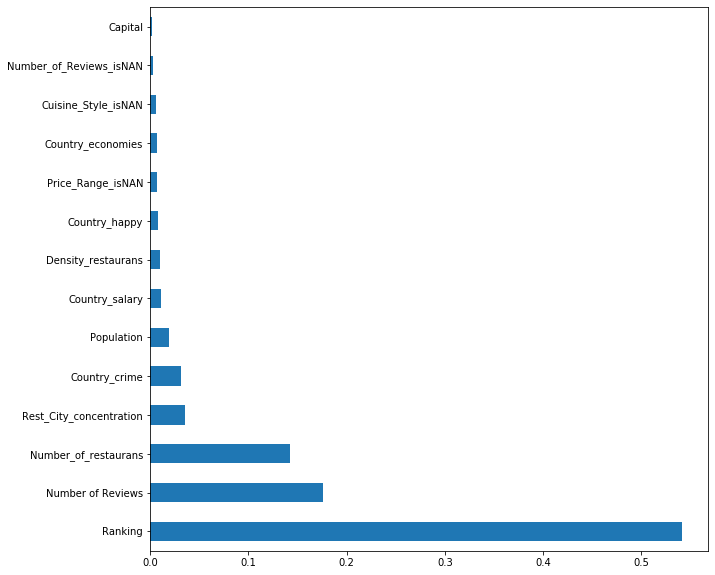

In [28]:
df_tmp = df[['Ranking', 'Rating', 'Number of Reviews', 'Cuisine_Style_isNAN', 'Price_Range_isNAN', 'Number_of_Reviews_isNAN',
             'Number_of_restaurans', 'Population', 'Density_restaurans', 'Capital', 'Rest_City_concentration','Country_economies','Country_salary', 'Country_crime', 'Country_happy']]

MAE(df_tmp)

#### уже не плохо

##  Cuisine

### Преобразуем стили кухонь в списки

In [29]:
df['Cuisine_Style_list'] = df['Cuisine Style'].str[1:-1].str.strip().str.split(',')
df['Cuisine_Style_list'].fillna('U', inplace=True) # неуказанная кухня станет "U" (Unknown)
df.drop(columns='Cuisine Style', inplace=True)

### Посмотрим какие кухни бывают

In [30]:
cuisine_set = set()
for cuis_list in df['Cuisine_Style_list']:
    for cuis in cuis_list:
        cuisine_set.add(cuis.replace("'", '').strip())

print('Всего кухонь: ', len(cuisine_set))

Всего кухонь:  126


*Считаем сколько раз кухня встречается в ресторанах*

In [31]:
cuisine_count = dict.fromkeys(cuisine_set, 0)
for cuis in cuisine_set:
    for cuis_list in df['Cuisine_Style_list']:
        if cuis in cuis_list:
            cuisine_count[cuis] += 1

cuisine_count = pd.Series(cuisine_count)
cuisine_count.sort_values(ascending=False)

U                 9283
Contemporary         0
Czech                0
Malaysian            0
Sushi                0
                  ... 
Hawaiian             0
Brew Pub             0
Middle Eastern       0
Caucasian            0
Fast Food            0
Length: 126, dtype: int64

#### Создадим параметр  - количество кухонь в ресторане.


In [32]:
df['Cuisine_count'] = df['Cuisine_Style_list'].apply(
    lambda x: 1 if x == 1 else len(x))

### Ranking — место, которое занимает ресторан среди всех ресторанов городa

*Посмотрим на данные.*

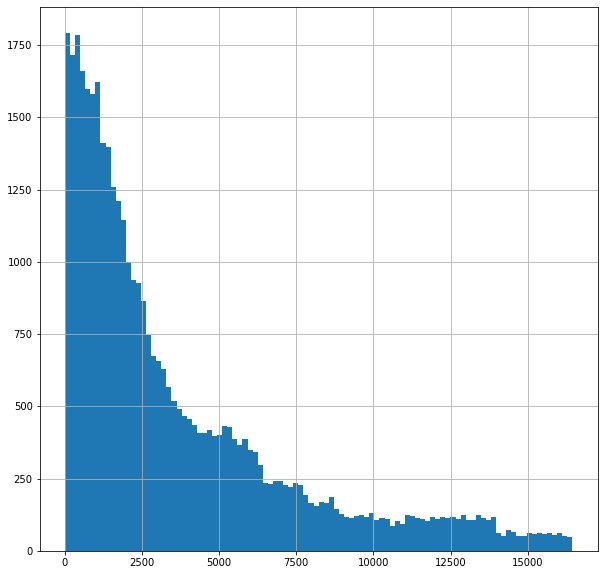

In [33]:
hist(df.Ranking,bins = 100)

**Топ 10**

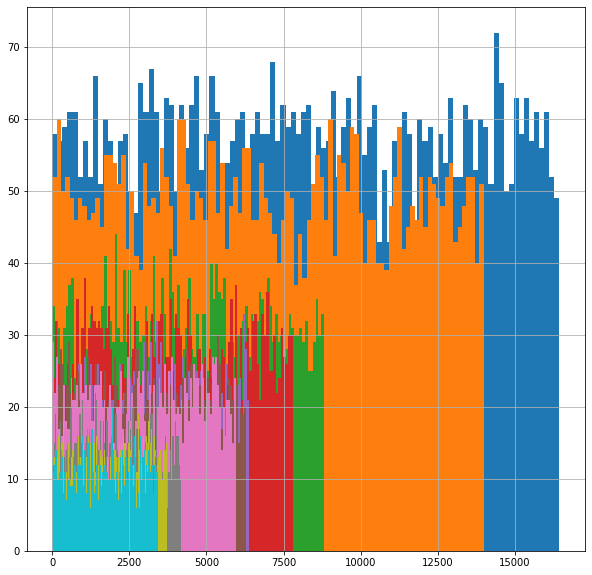

In [34]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

##### Очевидно, что если ресторан занимает 5е место из 1000, то он очень хороший, а если 5е место из 10, то он средний.
* получается, что Ranking имеет нормальное распределение, 
* просто в больших городах больше ресторанов, из-за мы этого имеем смещение

#### Создадим новый параметр - относительного ранга

In [35]:
df['Relative_rank'] = df['Ranking'] / df['Number_of_restaurans']

## Price Range— диапазон цен в ресторане

In [36]:
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

* Т.к. половина ресторанов имеют среднюю цену , то и пропуски заменим самым популярным значением.*

In [37]:
df['Price Range'].fillna('$$ - $$$', inplace=True)

*Преобразуем диапазон цен в числовой формат (1 - низкий уровень цен, 2 - средний, 3 - высокий)*

In [38]:
price_map = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['Price Range'].replace(price_map, inplace=True)

## Number of Reviews — количество отзывов о ресторане

*Показатель хорош сам по себе, поэтому его оставим в датафрейме без изменений.*



###  Рассмотрим распределение количества отзывов по городам.

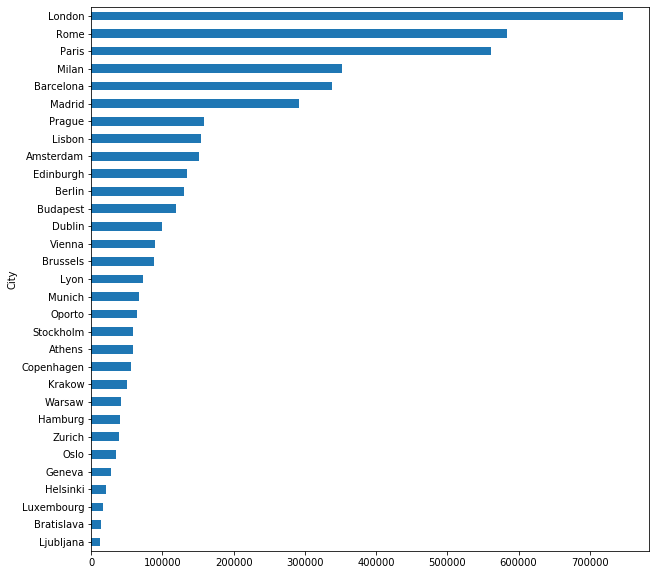

In [39]:
df_tmp = df.groupby(['City'])[
    'Number of Reviews'].sum().sort_values(ascending=False)
df_tmp.sort_values().plot(kind='barh')

### Добавим новый признак  - количество отзывов о ресторанах в городе и ранг ресторана относительно количества отзывов о ресторанах в городе.

In [40]:
df['Rev_in_city'] = df['City'].apply(lambda x: df_tmp[x])

In [41]:
df['Relative_rank_rev'] = df['Ranking'] / df['Rev_in_city']

## Reviews — данные о двух отзывах, которые отображаются на сайте ресторана

In [42]:
def processing_reviews(string):
    """Обработка для Reviews"""
    string = string.replace(']]', '')
    string = string.replace("'", '')
    string = string.split('], [')[1]
    string = string.split(', ')
    return string

*Пока столбец содержит текстовые данные, поищем ключевые слова в отзывах, которые могут повлиять на рейтинг и выведем наличие каждого ключевого слова в отдельный столбец:*

In [43]:
def find_words(df, word):
    """Создаем колонку с 1/0 для искомого слова в обзоре"""
    col_name = f'Rev_{word}'
    d = {col_name: 0}
    df = df.assign(**d)
    df.loc[df['Reviews'].str.lower().str.contains(word), col_name] = 1
    return df

words = ['terrible',
         'horrible',
         'not good',
         'disappointing',
         'worst',
         'better',
         'bad',
         'excellent',
         'best',
         'amazing',
         'great']

for word in words:
    df = find_words(df, word)

### Даты отзывов

*Продолжим работать с отзывами.*

###  Создадим признак с  первой и последней датой отзывов

In [44]:
df['Reviews_date_temp'] = df['Reviews'].apply(processing_reviews)
df['Reviews_date_first'] = df['Reviews_date_temp'].apply(
    lambda x: x[1] if len(x) == 2 else None)
df['Reviews_date_last'] = df['Reviews_date_temp'].apply(
    lambda x: x[0] if len(x) > 0 else None)

# Преобразуем в формат дат
df['Reviews_date_first'] = pd.to_datetime(df['Reviews_date_first'])
df['Reviews_date_last'] = pd.to_datetime(df['Reviews_date_last'])

#### Используем среднюю дату, что заполнить пропуски

In [45]:
t = df['Reviews_date_last'].mean()

df['Reviews_date_first'].fillna(t, inplace=True)
df['Reviews_date_last'].fillna(t, inplace=True)

#### Создадим параметр сколько дней прошло между отзывами и сколько дней прошло с даты последнего отзыва до условной сегодняшней даты. 

In [46]:
df['date_delta'] = (df['Reviews_date_last'] - df['Reviews_date_first']).dt.days

In [47]:
df['date_delta_today'] = (date_today - df['Reviews_date_last']).dt.days

Удалим лишние столбцы, на основе которых работали с датами.

In [48]:
df.drop(['Reviews', 'Reviews_date_temp', 'Reviews_date_first',
         'Reviews_date_last'], axis=1, inplace=True)

#### URL_TA — URL страницы ресторана на TripAdvosor

In [49]:
def processing_url(string):
    """Обработка для URL_TA"""
    string = string.replace('/Restaurant_Review-g', '')
    string = string.split('-')
    return int(string[0])

*В url страницы кроме идентификатора ресторана, закодирован идентификатор города с префиксом 'g'*

####  Добавим данный параметр индекс города в url.

In [50]:
df['url_ta_index'] = df['URL_TA'].apply(processing_url)
df.drop(['URL_TA'], axis=1, inplace=True)

## ID_TA — идентификатор ресторана в базе данных TripAdvisor

*Данный параметр представляет собой числовой идентификатор с префиксом 'd'.*

*Уберем префикс 'd' чтобы остались только числовые значения.*

In [51]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))

## Промежуточные итоги

*Посмотрим корреляции полученных признаков*

None                            Rating
Relative_rank           -0.542702
Relative_rank_rev       -0.431821
Ranking                 -0.368371
Rev_worst               -0.110762
Rev_terrible            -0.093284
Rev_bad                 -0.092019
date_delta_today        -0.091565
Rev_horrible            -0.076047
Restaurants_in_Country  -0.071220
Rev_disappointing       -0.069555
Price_Range_isNAN       -0.064567
Number_of_restaurans    -0.061376
Rev_not good            -0.047355
Cuisine_Style_isNAN     -0.038263
Density_restaurans      -0.037399
Rev_better              -0.034274
Rev_in_city             -0.033775
Country_happy           -0.028682
Price Range             -0.028588
Population              -0.024062
Country_salary          -0.013841
Country_economies       -0.009215
Rest_City_concentration -0.003396
url_ta_index            -0.001099
date_delta               0.002541
Number_of_Reviews_isNAN  0.008386
Capital                  0.022567
Country_crime            0.025093
Number of

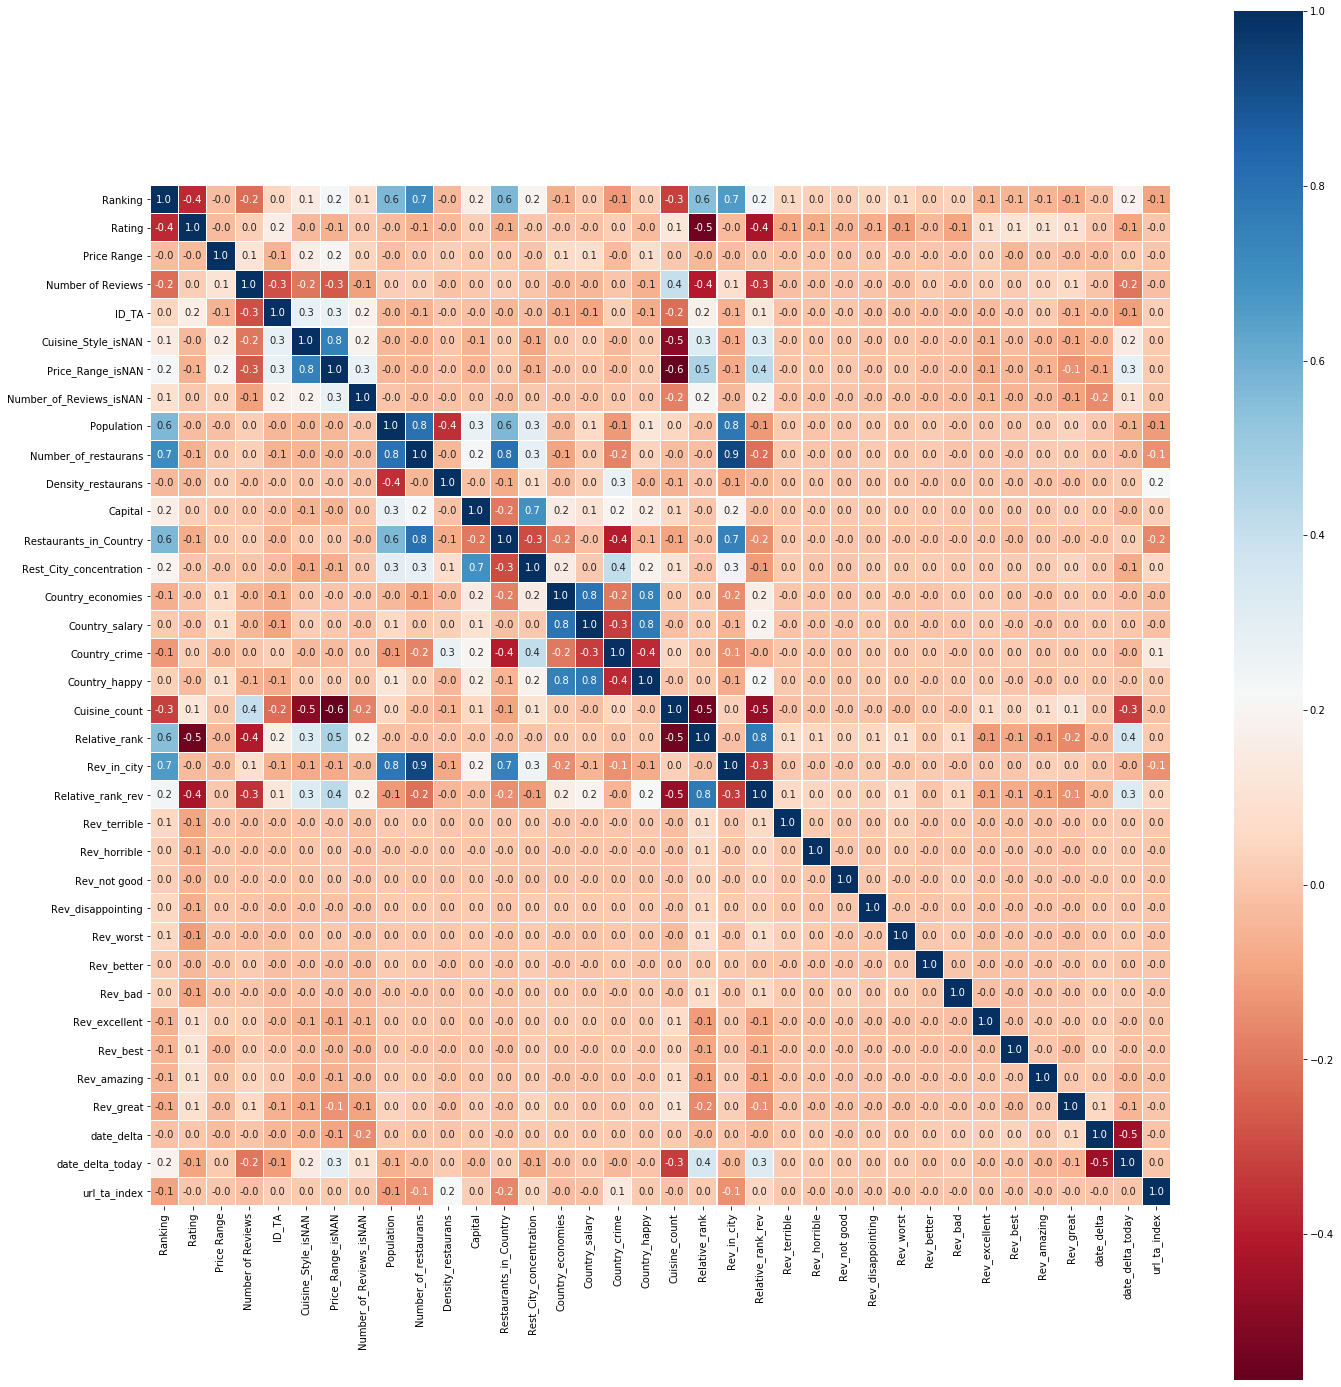

In [52]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
print(plt.tight_layout(),pd.DataFrame(df.corr()['Rating']).sort_values('Rating'))

*Есть довольно сильно скоррелированные параметры, однако удалять их не будем для более точной работы модели.*

### Переформатируем информацию о странах, городах и о  кухнях в dummy-переменные.

In [53]:
df = pd.get_dummies(df, columns=['City', 'Country'])

In [54]:
for cuis in cuisine_set:
    df[cuis] = 0
    df[cuis] = df['Cuisine_Style_list'].apply(lambda x: 1 if cuis in x else 0)

df.drop(['Cuisine_Style_list'], axis=1, inplace=True)

## Финальный тест модели

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 216 entries, Ranking to Azerbaijani
dtypes: float64(11), int64(148), uint8(57)
memory usage: 50.7 MB


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



MAE: 0.1600625



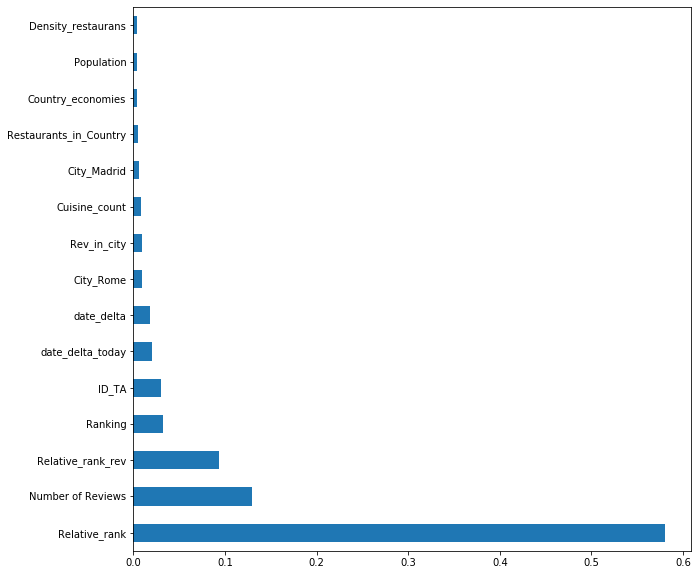

In [56]:
MAE(df)

## Мы создали свою первую модель с отклонением в 0.16

###  Выводы

* В данной работе были подробно исследованы признаки дата фрейма, а также построена модель, предсказывающая рейтинг ресторана.
* Была осуществлённа пред обработка.  Очистили и создали новые признаки. Новые признаки были сформированны из имеющихся и была взята информация из внешних источников